# COVID metabolite meta network example using data from MetaboLights

Here we use an additional study (MTBLS6739) to validate the biomarkers found in the metabolite meta-network. 

In [ ]:
# from COVID_study_processing import MTBLSDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
import libchebipy
import cmcrameri.cm as cmc
import scipy.stats as stats
from matplotlib import pyplot as plt
import marsilea as ma
from marsilea.upset import UpsetData
from marsilea.plotter import Colors, Labels


import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.stats.multitest import multipletests
import glob
import sspa
import numbers

sns.set_theme(
    style='whitegrid',
    palette='Paired',
#     font='Arial',
)


In [2]:
# download pathways
reactome_paths = sspa.process_reactome(
    organism='Homo sapiens',
    download_latest=True,
    omics_type='metabolomics',
    filepath='.' # save to current directory
)

Beginning Reactome download...
Reactome DB file saved to ./Reactome_Homo_sapiens_pathways_ChEBI_R90.gmt
Complete!


In [ ]:

class MTBLSDataset:
    '''
    Class representing a Metabolights dataset.

    Parameters:
    - file_path (str): The path to the directory containing .maf file and sample metadata file from MetaboLights
    - id (str): The MetaboLights identifier of the dataset.
    - node_name (str): node name, can be the same as id
    - md_group (str): The metadata column within the sample metadata file.
    - md_filter (dict): Dictionary specifying which metadata label is case and which is the control (e.g. {'Case':'Severe','Control': 'Mild'})
    - identifier (str, optional): The identifier column name. Defaults to 'database_identifier'.
    - remove_suffix (int, optional): The number of characters to remove from the end of the sample names. Defaults to None.
    - remove_prefix (int, optional): The number of characters to remove from the beginning of the sample names. Defaults to None.
    - outliers (list, optional): The list of sample IDs to be removed as outliers. Defaults to None.
    - pathway_level (bool, optional): Whether to perform analysis at the pathway level. Defaults to False.

    Attributes:
    - raw_data (DataFrame): The raw data from the dataset.
    - compound_mappers (None): Placeholder for DataFrame of alternative identifiers.
    - processed_data (DataFrame): The processed data from the dataset.
    - DA_metabolites (None): Placeholder for DA metabolites DataFrame containing results of DA testing.
    - pathway_data (None): Placeholder for pathway transformed data matrix.
    - pathway_coverage (None): Placeholder for pathway coverage dictionary

    Methods:
    - read_data(): Reads the data from the dataset file.
    - preprocess_data(): Preprocesses the raw data.
    - get_pathway_data(): ssPA transformation 
    - plot_qc(): Plots PCA and box plots
    - da_testing(): Performs differential analysis testing.
    '''

    def __init__(self, file_path, id, node_name, md_group, md_filter, identifier='database_identifier', remove_suffix=None, remove_prefix=None,  outliers=None, pathway_level=False):
        self.file_path = file_path
        self.raw_data = None
        self.remove_suffix = remove_suffix
        self.remove_prefix = remove_prefix
        self.compound_mappers = None
        self.processed_data = None
        self.metadata = None
        self.id = id
        self.node_name = node_name
        self.md_group = md_group
        self.md_filter = md_filter
        self.DA_metabolites = None
        self.identifier = identifier
        self.outliers = outliers
        self.pathway_data = None
        self.pathway_level = pathway_level
        self.pathway_coverage = None

        self.read_data()
        # self.preprocess_data()
        self.get_pathway_data()
        self.da_testing()
        

    def read_data(self):
        '''
        Reads the data from the dataset file and sends it for preprocessing.

        Returns:
        - processed_data (DataFrame): The processed data from the dataset.
        - metadata (DataFrame): The metadata from the dataset.
        '''
        # check if there are multiple files in folder
        metadata = pd.read_csv(self.file_path + '/s_' + self.id + '.txt', sep = '\t', encoding='unicode_escape')

        metadata['Sample Name'] = metadata['Sample Name'].astype(str)
        if self.remove_suffix:
            metadata['Sample Name'] = metadata['Sample Name'].str[:-self.remove_suffix]
        if self.remove_prefix:
            metadata['Sample Name'] = metadata['Sample Name'].str[self.remove_prefix:]

        self.metadata = metadata

        files = glob.glob(self.file_path + '/*' + 'maf.tsv')
        if len(files) > 1:
            print(len(files), 'assay files found')
            # read in all files and concatenate
            dfs = []
            dfs_proc = []
            for f in files:
                df = pd.read_csv(f, sep='\t')
                dfs.append(df)
                # df.index = df['Samples']
                self.raw_data = df

                df_proc = self.preprocess_data()
                dfs_proc.append(df_proc)

            self.raw_data = pd.concat(dfs, axis=1)
            
            # inner join removes samples not present in all assays
            proc_data = pd.concat(dfs_proc, axis=1, join='inner')
            # aveage same columns
            proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])
            # remove duplicate 'Group' columns
            proc_data = proc_data.loc[:, ~proc_data.columns.duplicated()]

            # move group column to end
            cols = [col for col in proc_data.columns if col != 'Group'] + ['Group']
            self.processed_data = proc_data[cols]

        else:
            print(len(files), 'assay file found')
            data = pd.read_csv(files[0], sep='\t')
            # data.index = data['Samples']
            self.raw_data = data

            proc_data = self.preprocess_data()
            proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])
            self.processed_data = proc_data

        return self.processed_data, self.metadata


    def preprocess_data(self):
        '''
        Preprocesses the raw data (filtering, imputation, scaling).

        Returns:
        - data_scaled (DataFrame): The preprocessed and scaled data.
        '''
        data_filt = self.raw_data.copy()

        # repalce decimal in mz ratios
        try:
            data_filt['mass_to_charge'] = data_filt['mass_to_charge'].round(2)
            data_filt['mass_to_charge'] = data_filt['mass_to_charge'].astype('str').apply(lambda x: re.sub(r'\.', '_', x))
        except KeyError:
            pass

        self.all_ids = data_filt.iloc[:, ~data_filt.columns.isin(self.metadata['Sample Name'].tolist())]

        # # set chebi as index
        data_filt = data_filt[data_filt[self.identifier].notna()]

        # if there are no chebis in the whole assay file, drop it
        if data_filt.shape[0] == 0:
            print('No CHEBIS for assay')
            return None
        else:
            data_filt = data_filt[data_filt[self.identifier] != 'unknown']
            data_filt.index = data_filt[self.identifier]

            # remove assay specific sample suffixes
            if self.remove_suffix:
                data_filt.columns = data_filt.columns.str[:-self.remove_suffix]

            # keep only abundance data filtering on samples
            # store alternative identifiers in a dict
            samples = self.metadata['Sample Name'].tolist()
            ids = data_filt.iloc[:, ~data_filt.columns.isin(samples)]
            self.id_dict = ids.to_dict()
            data_filt = data_filt.iloc[:, data_filt.columns.isin(samples)]

            # ensure all data is numeric
            data_filt = data_filt.apply(pd.to_numeric, errors='coerce')

            # Transpose
            data_filt = data_filt.T

            # There will be QC samples so better filter on metadata at this point
            md_dict = dict(zip(self.metadata['Sample Name'], self.metadata[self.md_group]))
            # add metadata column
            data_filt['Group'] = data_filt.index.map(md_dict)

            # filter on metadata
            data_filt = data_filt[data_filt['Group'].isin(self.md_filter.values())]
            data_filt = data_filt.drop(columns=['Group'])
            # drop outliers
            if self.outliers:
                data_filt = data_filt.drop(self.outliers)

            # Missingness checks 
            # replace empty strings with NaN
            data_filt = data_filt.replace(['', ' '], np.nan)
            # Delete colums and rows where all values are missing
            data_filt = data_filt.dropna(axis=0, how='all')
            data_filt = data_filt.dropna(axis=1, how='all')

            # Delete rows and columns where all values are 0 
            data_filt = data_filt.loc[:, (data_filt != 0).any(axis=0)]
            data_filt = data_filt.loc[(data_filt != 0).any(axis=1), :]

            data_filt = data_filt.dropna(axis=1, thresh=0.5*data_filt.shape[0])
            missing_pct = data_filt.isnull().sum().sum() / (data_filt.shape[0] * data_filt.shape[1]) * 100
            print(f"Missingness: {missing_pct:.2f}%")

            # impute missing values
            imputer = KNNImputer(n_neighbors=2, weights="uniform").set_output(transform="pandas")
            data_imputed = imputer.fit_transform(data_filt)

            # log transformation
            data_imputed = np.log(data_imputed + 1)

            # standardize
            scaler = StandardScaler().set_output(transform="pandas")
            data_scaled = scaler.fit_transform(data_imputed)

            data_scaled['Group'] = data_scaled.index.map(md_dict)
            self.processed_data = data_scaled

            return data_scaled
    
    def get_pathway_data(self):
        '''
        Performs ssPA pathway transformation on the data.
        '''
        reactome_paths = sspa.process_gmt(infile='Reactome_Homo_sapiens_pathways_ChEBI_R90.gmt')
        reactome_dict = sspa.utils.pathwaydf_to_dict(reactome_paths)
        # remove CHEBI: from column names
        data = self.processed_data
        data.columns = data.columns.str.removeprefix("CHEBI:")

        # store pathway coverage stats
        cvrg_dict = {k: len(set(data.columns).intersection(set(v))) for k, v in reactome_dict.items()}
        self.pathway_coverage = cvrg_dict

        scores = sspa.sspa_KPCA(reactome_paths).fit_transform(data.iloc[:, :-1])
        scores['Group'] = self.processed_data['Group']
        self.pathway_data = scores
    
    def plot_qc(self):
        '''
        Plots PCA and boxplots, returns figure
        '''
        # PCA biplot
        pca = PCA(n_components=2).set_output(transform="pandas")
        pca_result = pca.fit_transform(self.processed_data.iloc[:, :-1])
        self.pca = pca_result

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        sns.scatterplot(
            x=pca_result.iloc[:, 0], y=pca_result.iloc[:, 1],
            hue="Group",
            data=self.processed_data,
            alpha=0.7,
            ax=ax1
        )

        # every nth feature - display 20 features
        feature_idx = int(self.processed_data.shape[1]/20)
        filt_features = self.processed_data.iloc[:, ::feature_idx]
        filt_features['Group'] = self.processed_data['Group']
        data_long = filt_features.melt(id_vars='Group')
        sns.boxplot(data=data_long, ax=ax2, hue='Group', x='variable', y='value')
        ax2.tick_params(axis='x', rotation=90)
        ax2.axhline(0, color='red', linestyle='--')
        plt.show()

    def da_testing(self):
        '''
        Performs differential analysis testing, adds pval_df attribute containing results.
        '''
        if self.pathway_level == True:
            dat = self.pathway_data
        else:
            dat = self.processed_data

        # t-test for two groups
        case = self.md_filter['Case']
        control = self.md_filter['Control']
        
        stat, pvals = stats.ttest_ind(dat[dat['Group'] == case].iloc[:, :-1],
                        dat[dat['Group'] == control].iloc[:, :-1],
                        alternative='two-sided', nan_policy='raise')
        pval_df = pd.DataFrame(pvals, index=dat.columns[:-1], columns=['P-value'])
        pval_df['Stat'] = stat
        pval_df['Direction'] = ['Up' if x > 0 else 'Down' for x in stat]
        self.pval_df = pval_df

        # fdr correction 
        pval_df['FDR_P-value'] = multipletests(pvals, method='fdr_bh')[1]

        # return significant metabolites
        self.DA_metabolites = pval_df[pval_df['FDR_P-value'] < 0.05].index.tolist()
        print(f"Number of differentially abundant metabolites: {len(self.DA_metabolites)}") 

        # generate tuples for nx links
        self.connection = [(self.node_name, met) for met in self.DA_metabolites]
        self.full_connection = [(self.node_name, met) for met in self.processed_data.columns[:-1]]


### Processing MTBLS6739

In [4]:
# MTBLS6739
s6739 = MTBLSDataset(
    file_path = 'Studies/MTBLS6739', 
    id = 'MTBLS6739', 
    node_name = 'MTBLS6739', 
    md_group = 'Factor Value[Disease]', 
    md_filter = {'Case': 'COVID-19', 'Control': 'Negative'},
    outliers=['plasma_ssa_122', 'plasma_ssa_015'],
)

1 assay file found
Missingness: 0.00%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_21972\995044383.py:112: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 27


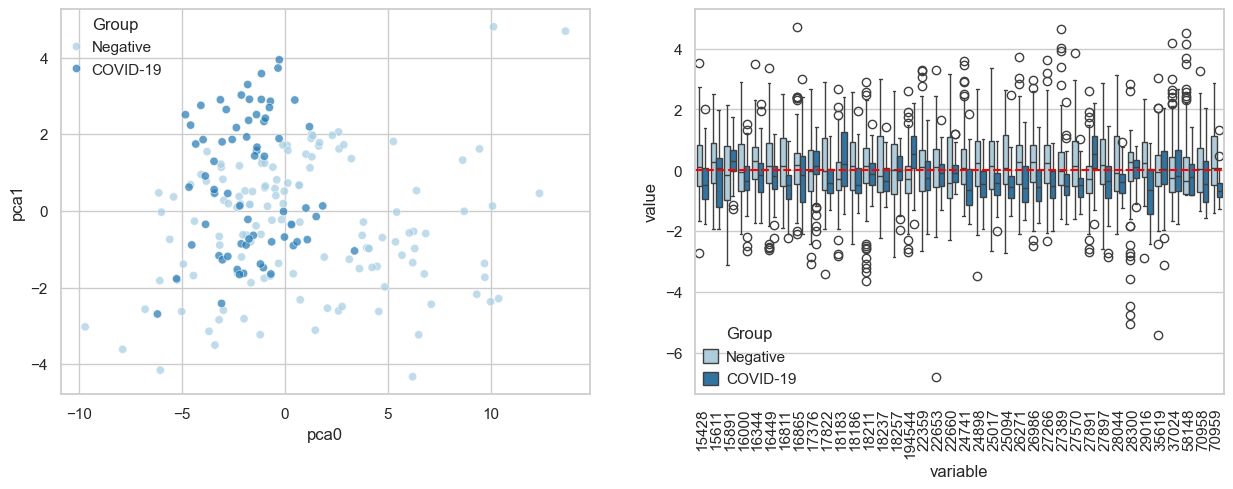

In [8]:
s6739.plot_qc()

In [5]:
# MTBLS2224
s2224 = MTBLSDataset(
    file_path = 'Studies/MTBLS2224', 
    id = 'MTBLS2224', 
    node_name = 'MTBLS2224', 
    md_group = 'Factor Value[COVID Infection]', 
    md_filter = {'Case': 'Positive', 'Control': 'Negative'},
    outliers='FU22')

3 assay files found
Missingness: 0.00%
Missingness: 0.00%
Missingness: 0.00%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_22064\995044383.py:97: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 759


c:\Users\cw2019\AppData\Local\R\cache\R\basilisk\1.16.0\0\envs\py12\Lib\site-packages\scipy\stats\_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


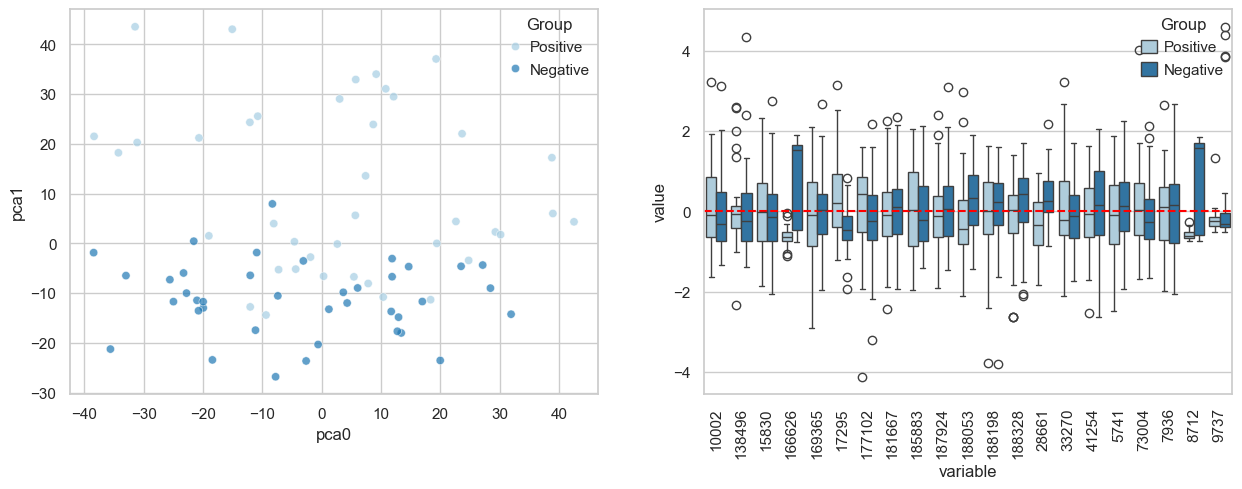

In [10]:
s2224.plot_qc()

In [6]:
s6844 = MTBLSDataset(
    file_path = 'Studies/MTBLS6844', 
    id = 'MTBLS6844', 
    node_name = 'MTBLS6844', 
    md_group = 'Factor Value[Disease]', 
    md_filter = {'Case':'Severe','Control': 'Mild'},
    outliers='SEVERE6')

C:\Users\cw2019\AppData\Local\Temp\ipykernel_22064\995044383.py:112: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


1 assay file found
Missingness: 0.00%
Number of differentially abundant metabolites: 0


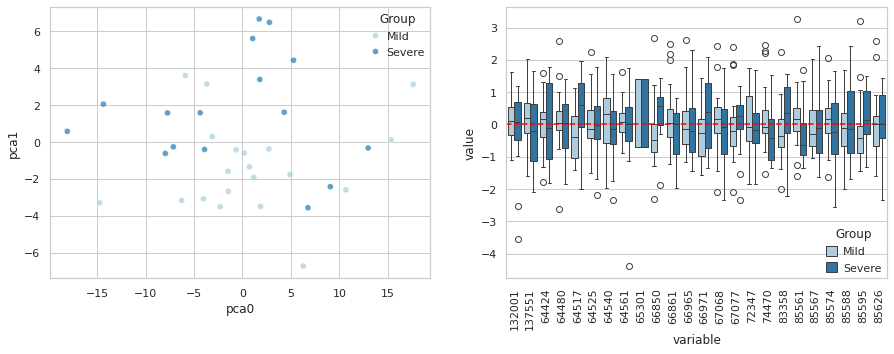

In [17]:
s6844.plot_qc()

In [7]:
s1866 = MTBLSDataset(
    file_path = 'Studies/MTBLS1866', 
    id = 'MTBLS1866', 
    node_name = 'MTBLS1866', 
    md_group = 'Factor Value[Medical case]', 
    md_filter = {'Control': 'HEALTHY', 'Case': 'COVID-19'},
    outliers='SA 8',
    )

3 assay files found
Missingness: 0.00%
Missingness: 0.00%
Missingness: 0.00%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_22064\995044383.py:97: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 249


c:\Users\cw2019\AppData\Local\R\cache\R\basilisk\1.16.0\0\envs\py12\Lib\site-packages\scipy\stats\_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


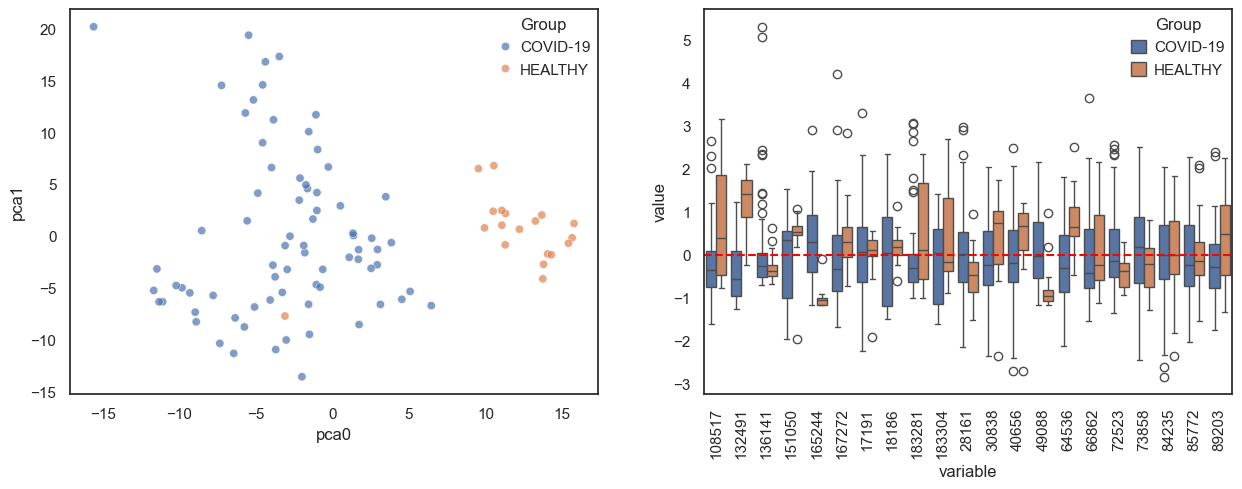

In [50]:
s1866.plot_qc()

In [8]:
s2336 = MTBLSDataset(
    file_path = 'Studies/MTBLS2336', 
    id = 'MTBLS2336', 
    node_name = 'MTBLS2336', 
    md_group = 'Factor Value[Disease]', 
    md_filter = {'Case':'COVID-19', 'Control':'Healthy (control)'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_22064\995044383.py:112: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


1 assay file found
Missingness: 0.00%
Number of differentially abundant metabolites: 11


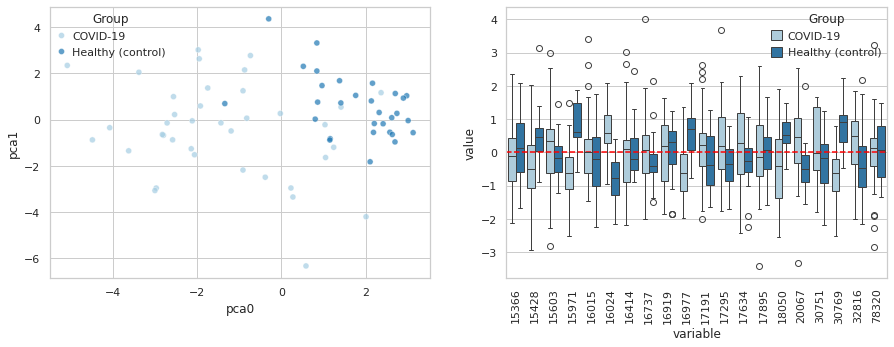

In [22]:
s2336.plot_qc()

In [9]:
s2542 = MTBLSDataset(
    file_path = 'Studies/MTBLS2542', 
    id = 'MTBLS2542', 
    remove_suffix=4,
    node_name = 'MTBLS2542', 
    md_group = 'Factor Value[Disease severity]', 
    md_filter = {'Control':'Mild', 'Case':'Death'})

4 assay files found
No CHEBIS for assay
No CHEBIS for assay
Missingness: 0.00%
Missingness: 0.00%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_22064\995044383.py:97: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 409


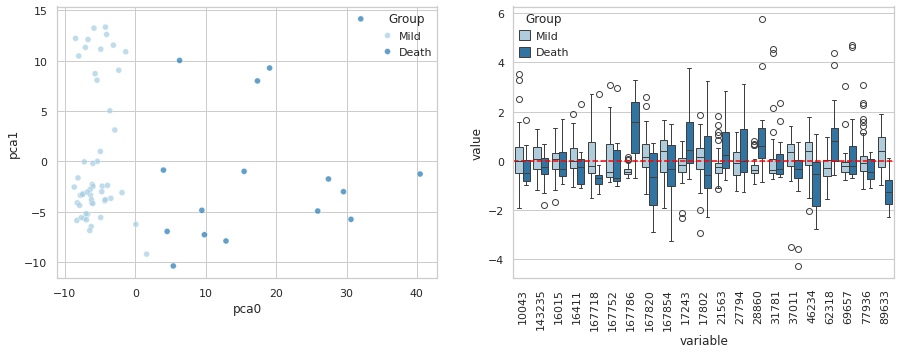

In [24]:
s2542.plot_qc()

In [10]:
s2291 = MTBLSDataset(
    file_path = 'Studies/MTBLS2291', 
    id = 'MTBLS2291', 
    node_name = 'MTBLS2291', 
    remove_prefix=9,
    md_group = 'Factor Value[Disease severity]', 
    md_filter = {'Control':'Negative COVID-19', 'Case':'Severe COVID-19'},
    outliers=['CovidNeg_P251_P_3',
 'CovidNeg_P251_P_4',
 'CovidNeg_P252_P_3',
 'CovidNeg_P252_P_4',
 'CovidNeg_P253_P_3',
 'CovidNeg_P253_P_4',
 'CovidNeg_P254_P_3',
 'CovidNeg_P254_P_4',
 'CovidNeg_P257_P_3',
 'CovidNeg_P257_P_4',
 'CovidNeg_P258_P_3',
 'CovidNeg_P258_P_4',
 'CovidNeg_P259_P_3',
 'CovidNeg_P259_P_4',
 'CovidNeg_P260_P_3',
 'CovidNeg_P260_P_4',
 'CovidNeg_P261_P_3',
 'CovidNeg_P261_P_4',
 'CovidNeg_P262_P_3',
 'CovidNeg_P262_P_4',
 'CovidNeg_P263_P_3',
 'CovidNeg_P263_P_4',
 'CovidNeg_P264_P_3',
 'CovidNeg_P264_P_4',
 'CovidNeg_P265_P_3',
 'CovidNeg_P265_P_4',
 'CovidNeg_P266_P_3',
 'CovidNeg_P266_P_4',
 'CovidNeg_P267_P_3',
 'CovidNeg_P267_P_4',
 'CovidNeg_P268_P_3',
 'CovidNeg_P268_P_4',
 'CovidNeg_P269_P_3',
 'CovidNeg_P269_P_4',
 'CovidNeg_P270_P_3',
 'CovidNeg_P270_P_4',
 'CovidNeg_P271_P_3',
 'CovidNeg_P271_P_4',
 'CovidSevere_P273_P_3',
 'CovidSevere_P273_P_4',
 'CovidSevere_P272_P_3',
 'CovidSevere_P272_P_4',
 'CovidSevere_P283_P_3',
 'CovidSevere_P283_P_4',
 'CovidSevere_P284_P_3',
 'CovidSevere_P284_P_4',
 'CovidSevere_P285_P_3',
 'CovidSevere_P285_P_4']
)

1 assay file found
Missingness: 18.21%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_22064\995044383.py:112: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 50


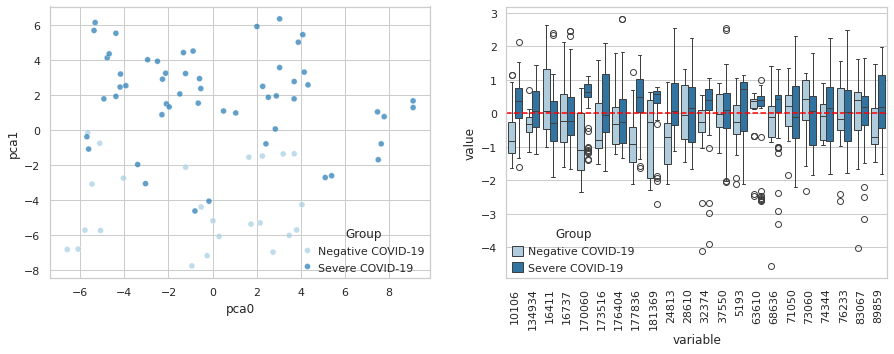

In [26]:
s2291.plot_qc()

In [11]:
s718 = MTBLSDataset(
    file_path = 'Studies/MTBLS718', 
    id = 'MTBLS718', 
    node_name = 'MTBLS718', 
    md_group = 'Factor Value[Condition]', 
    md_filter = {'Case':'COVID-19', 'Control':'Healthy Control'})

3 assay files found
Missingness: 0.00%
No CHEBIS for assay


C:\Users\cw2019\AppData\Local\Temp\ipykernel_22064\995044383.py:84: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep='\t')


No CHEBIS for assay


C:\Users\cw2019\AppData\Local\Temp\ipykernel_22064\995044383.py:97: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 1


In [12]:
s2014 = MTBLSDataset(
    file_path = 'Studies/MTBLS2014', 
    id = 'MTBLS2014', 
    node_name = 'MTBLS2014', 
    md_group = 'Factor Value[Disease]', 
    md_filter = {'Control':'Healthy', 'Case':'Patient (+) SARS-CoV-2'},
    outliers=['12JUN2020_AAA_COV_PL_068'])

1 assay file found
Missingness: 0.00%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_22064\995044383.py:112: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 9


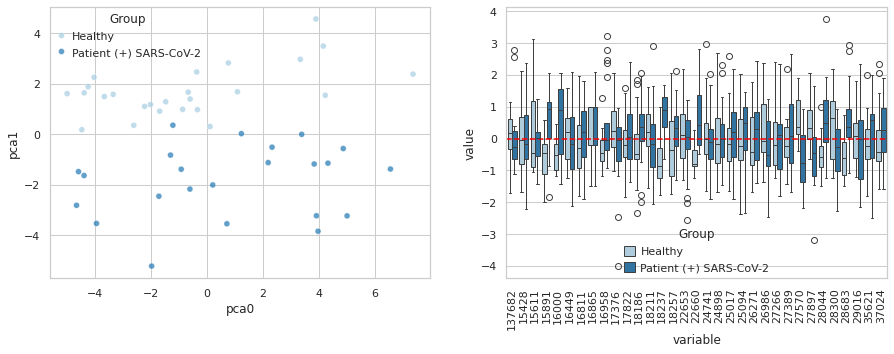

In [29]:
s2014.plot_qc()

In [5]:
# MTBLS3852
s3852 = MTBLSDataset(
    file_path = 'Studies/MTBLS3852', 
    id = 'MTBLS3852', 
    node_name = 'MTBLS3852', 
    md_group = 'Factor Value[Disease staging]', 
    md_filter = {'Case': 'severe COVID-19', 'Control': 'control'},
#     outliers=['plasma_ssa_122', 'plasma_ssa_015'],
)

1 assay file found
Missingness: 1.93%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_21972\995044383.py:112: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 20


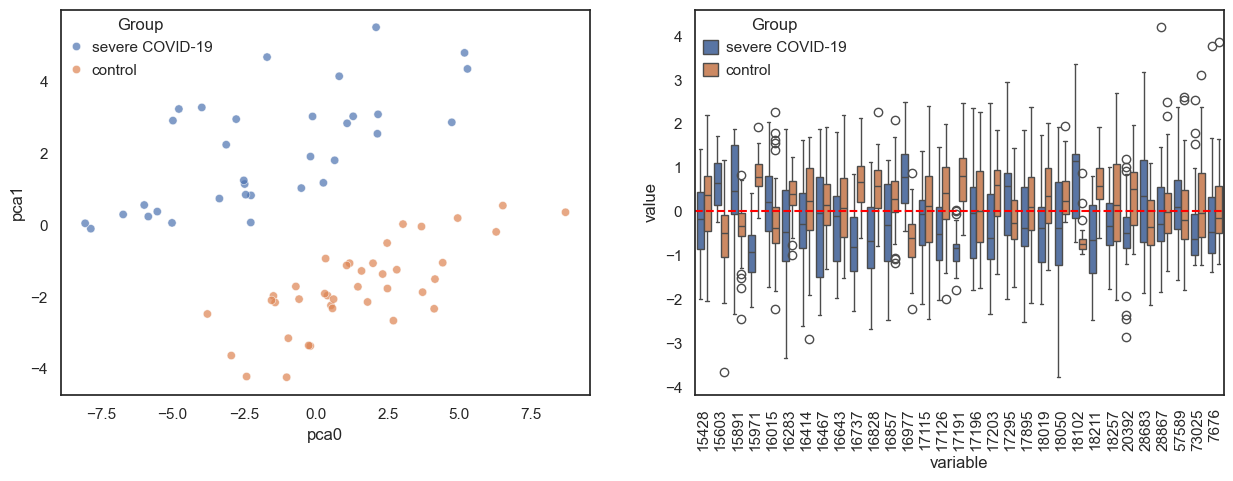

In [101]:
s3852.plot_qc()

## Differential metabolites per study

In [14]:
# studies for COVID19 case study which have enough DA metabo to build the graph
studies = [s2014, s1866, s2224, s2542, s2291, s2336]

In [15]:
DA_res = pd.DataFrame(
    zip([len(i.DA_metabolites) for i in studies], [len(i.processed_data.columns)-1 for i in studies]),
    index=[i.node_name for i in studies],
    columns=['DA_count', 'ChEBI and Identified metabolite count']
)

In [16]:
DA_res

,DA_count,ChEBI and Identified metabolite count
MTBLS2014,9,33
MTBLS1866,249,475
MTBLS2224,759,2586
MTBLS2542,409,696
MTBLS2291,50,130
MTBLS2336,11,20


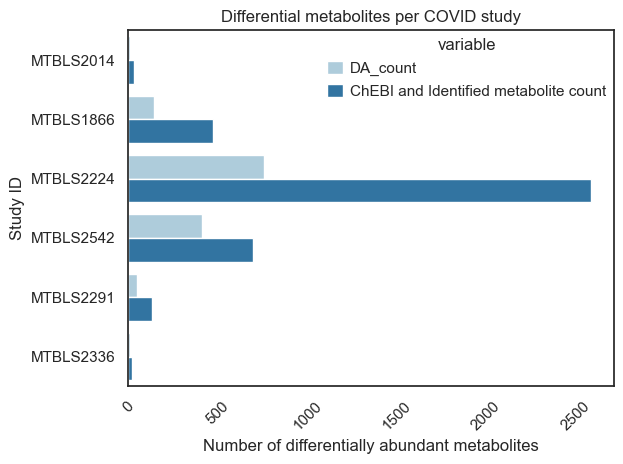

In [33]:
sns.set_style('white')
sns.barplot(
    data=DA_res.melt(ignore_index=False).reset_index(),
    y='index',
    x='value',
    hue='variable',
    orient='h'
)
plt.xlabel('Number of differentially abundant metabolites')
plt.ylabel('Study ID')
plt.title('Differential metabolites per COVID study')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
# count the number of identifier types per study
ids_counts = [pd.Series(i.all_ids.nunique(), name=i.id) for i in studies]

In [36]:
ids_counts = pd.concat(ids_counts, axis=1).T

In [37]:
ids_counts = ids_counts[['database_identifier',
 'chemical_formula',
 'smiles',
 'inchi',
 'metabolite_identification',
 'mass_to_charge',
 'retention_time',
 'reliability']]

In [38]:
ids_counts

,database_identifier,chemical_formula,smiles,inchi,metabolite_identification,mass_to_charge,retention_time,reliability
MTBLS2014,33.0,28.0,29.0,29.0,34.0,27.0,34.0,0.0
MTBLS1866,211.0,196.0,90.0,62.0,476.0,464.0,464.0,0.0
MTBLS2224,1094.0,929.0,1089.0,838.0,1153.0,857.0,568.0,0.0
MTBLS2542,0.0,0.0,0.0,0.0,177.0,1.0,154.0,0.0
MTBLS2291,934.0,1158.0,917.0,915.0,1325.0,1.0,1702.0,0.0
MTBLS2336,20.0,18.0,18.0,18.0,22.0,NaN,NaN,0.0


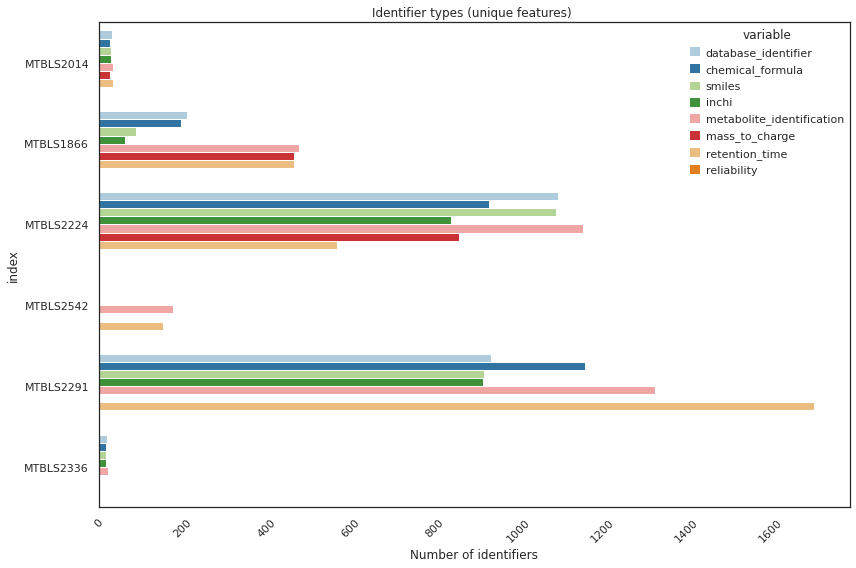

In [39]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=ids_counts.melt(ignore_index=False).reset_index(),
    y='index',
    x='value',
    hue='variable',
    orient='h'
)
plt.xticks(rotation=45)
plt.xlabel('Number of identifiers')
plt.title('Identifier types (unique features) ')
plt.tight_layout()
plt.show()

## Bipartite graph

In [17]:
def get_bipartite(studies):
    B = nx.Graph()
    # Add nodes with the node attribute "bipartite"-

    B.add_nodes_from([i.node_name for i in studies], bipartite=0)
    B.add_nodes_from(sum([i.DA_metabolites for i in studies], []), bipartite=1)
    # Add edges only between nodes of opposite node sets
    B.add_edges_from(sum([i.connection for i in studies], []))
    bottom_nodes, top_nodes = bipartite.sets(B)
    nx.is_connected(B)
    return B, bottom_nodes, top_nodes

In [18]:
covid_bpt, covid_bottom_nodes, covid_top_nodes = get_bipartite(studies)

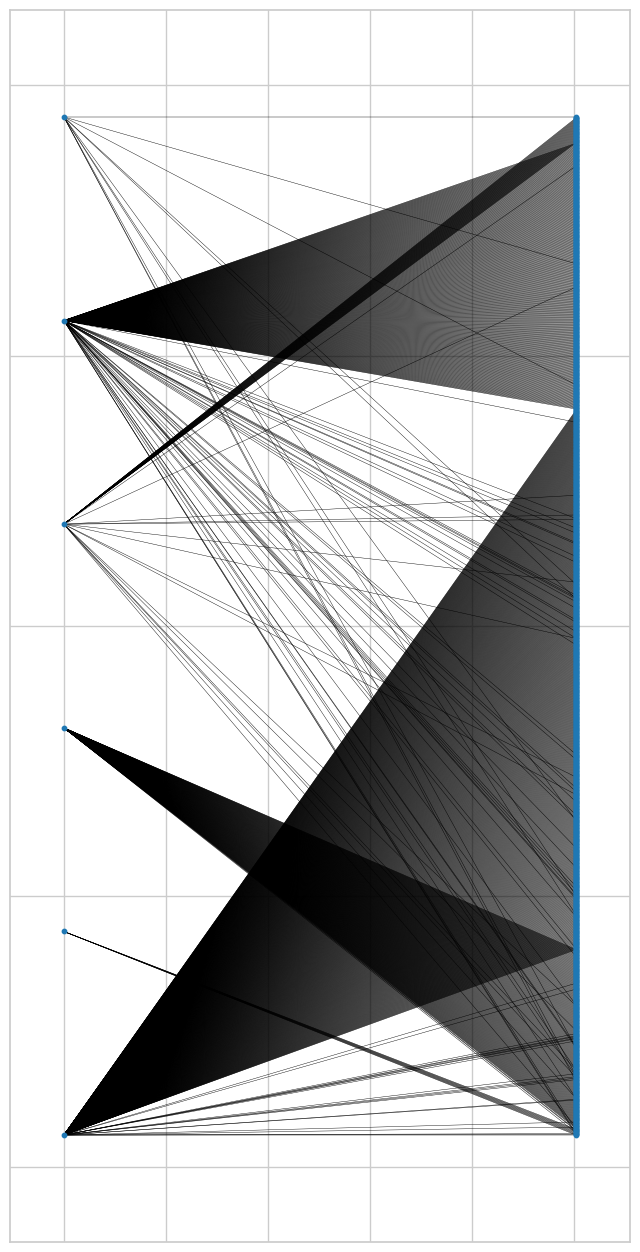

In [19]:
plt.figure(3,figsize=(8,16)) 
nx.draw_networkx(
    covid_bpt,
    pos = nx.drawing.layout.bipartite_layout(covid_bpt, covid_bottom_nodes),
    font_size=6,
    width = 0.3,
    with_labels=False,
    node_size=10,
    ) # Or whatever other display options you like

plt.show()


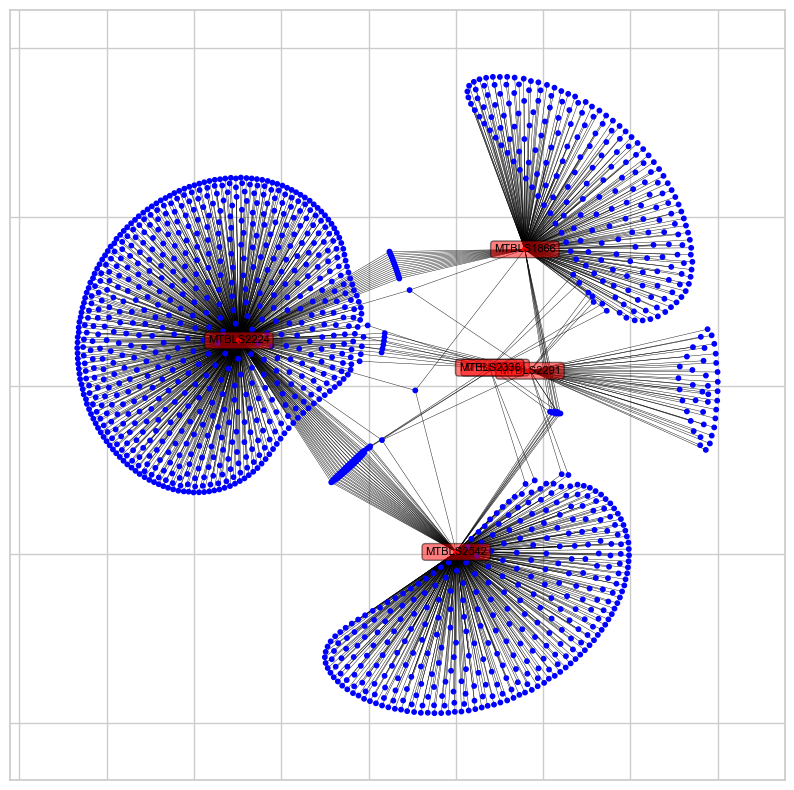

In [20]:
# force directed layout
pos = nx.drawing.layout.kamada_kawai_layout(covid_bpt)
color_map = []
labels = {}
for node in covid_bpt:
    if node in covid_bottom_nodes:
        color_map.append('red')
        labels[node] = node
    else: 
        color_map.append('blue')    
        # labels[node] = ''  


plt.figure(3,figsize=(10 ,10)) 
nx.draw_networkx(
    covid_bpt,
    pos = pos,
    font_size=6,
    width = 0.3,
    with_labels=False,
    node_size=10,
    node_color=color_map
    ) 

nx.draw_networkx_labels(covid_bpt, pos, labels,
                        bbox = dict(facecolor = "red", alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'),
                        font_size=8,
                        font_color='black')

plt.show()

In [21]:
biadj_mat = nx.bipartite.biadjacency_matrix(covid_bpt, row_order=covid_bottom_nodes, column_order=covid_top_nodes).toarray()
biadj_df = pd.DataFrame(biadj_mat, index=list(covid_bottom_nodes), columns=list(covid_top_nodes))

In [23]:
biadj_mat.shape

(6, 1395)

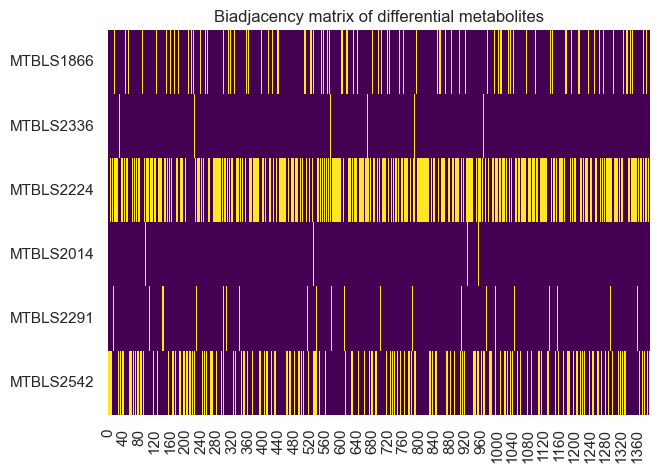

In [24]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(biadj_mat, cmap='viridis', cbar=False)
ax.set_yticklabels(covid_bottom_nodes, rotation=0)
ax.set_title('Biadjacency matrix of differential metabolites')
plt.show()


## Adjacency matrix

c:\Users\cw2019\AppData\Local\R\cache\R\basilisk\1.16.0\0\envs\py12\Lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


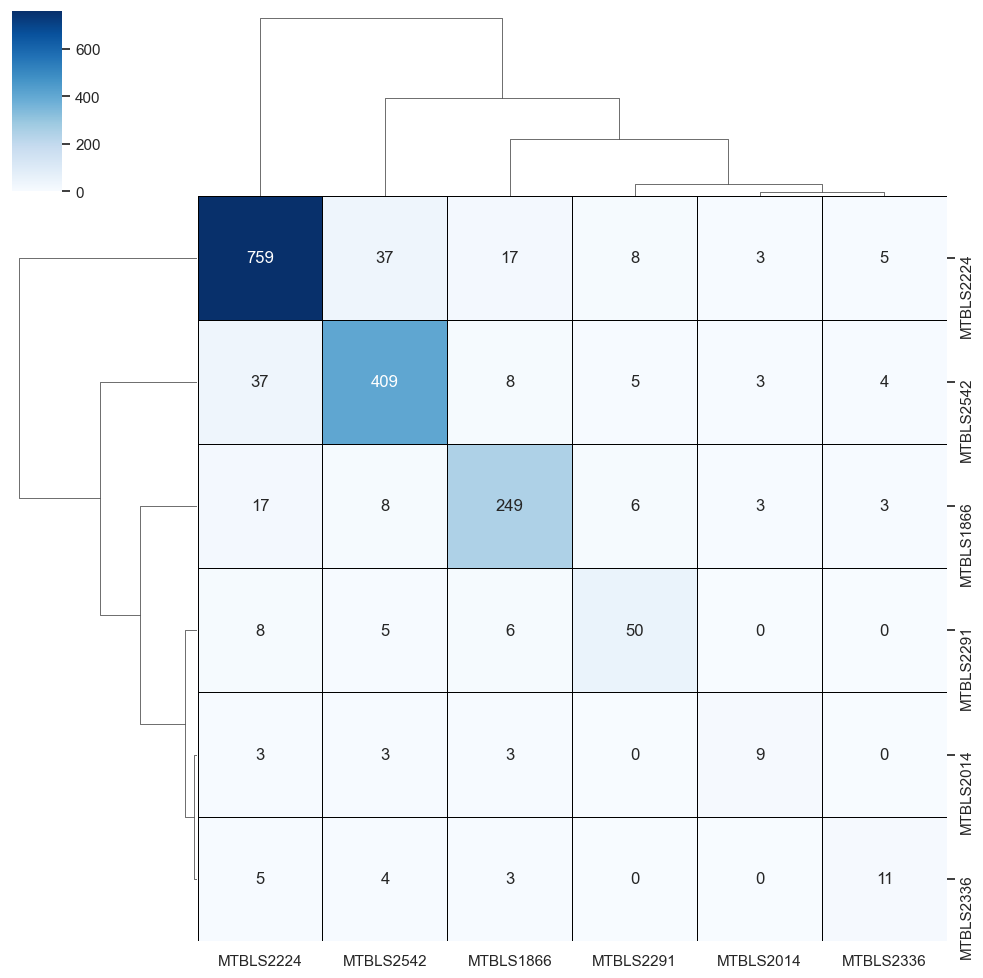

In [22]:
# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat = pd.DataFrame(biadj_mat @ biadj_mat.T, index=list(covid_bottom_nodes), columns=list(covid_bottom_nodes))

# fig, ax = plt.subplots(figsize=(7, 5))
sns.set(style='white')
sns.clustermap(
    adj_mat, 
    cmap='Blues', 
    square=True, 
    annot=True, 
    # cbar=False, 
    fmt='d', 
    linewidths=0.5, 
    linecolor='black' )
# ax.set_yticklabels(bottom_nodes, rotation=0)
# ax.set_xticklabels(bottom_nodes, rotation=90)
# ax.set_title('Similarity matrix of differential metabolites')
# plt.tight_layout()
plt.show()


In [23]:
# look at overlap of metabolites between studies

overlap = pd.DataFrame(
    np.zeros((len(studies), len(studies))), 
    index=[i.node_name for i in studies], 
    columns=[i.node_name for i in studies]
)

for i in range(len(studies)):
    for j in range(len(studies)):
        overlap.iloc[i, j] = len(set(studies[i].processed_data.iloc[:, :-1].columns) & set(studies[j].processed_data.iloc[:, :-1].columns))


c:\Users\cw2019\AppData\Local\R\cache\R\basilisk\1.16.0\0\envs\py12\Lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


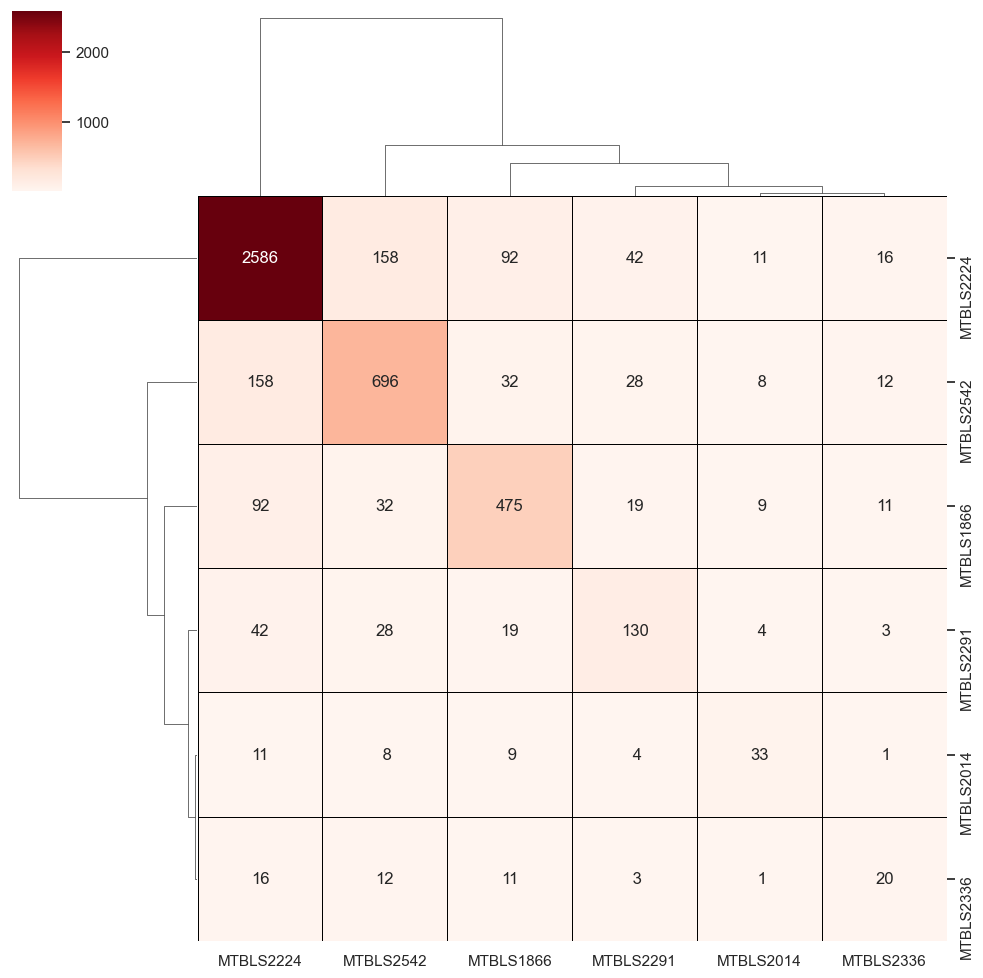

In [24]:

sns.set(style='white')
sns.clustermap(overlap, cmap='Reds', annot=True, square=True, fmt='2g', linewidths=0.5, linecolor='black')
plt.show()

## Disease-metabolite network

In [25]:
# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat_dmn = pd.DataFrame(biadj_mat.T @ biadj_mat, index=list(covid_top_nodes), columns=list(covid_top_nodes))


In [27]:

# make pandas edgelist
edgelist_dmn = adj_mat_dmn.stack().reset_index()
edgelist_dmn.columns = ['source', 'target', 'weight']
edgelist_dmn = edgelist_dmn[edgelist_dmn['weight'] > 1]


In [28]:
edgelist_dmn.sort_values('weight', ascending=False)

,source,target,weight
706376,20067,20067,3
1330388,16958,16958,3
415357,15843,18183,3
72592,15891,15891,3
1453887,18183,15843,3
...,...,...,...
557601,30813,24813,2
557558,30813,16958,2
557549,30813,28197,2
557393,30813,30769,2


In [28]:
biadj_df = pd.DataFrame(biadj_mat, index=list(covid_bottom_nodes), columns=list(covid_top_nodes))

In [29]:
biadj_df

,16552,85706,28044,167768,167765,28487,10353,32980,3455,3916,...,183265,179640,168669,36773,187916,17957,188276,16962,169554,188061
MTBLS2224,0,0,0,0,0,0,0,1,1,1,...,0,1,1,0,1,0,1,0,1,1
MTBLS2014,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MTBLS1866,0,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
MTBLS2291,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
MTBLS2542,1,0,0,1,1,0,1,0,0,0,...,0,0,0,1,0,1,0,1,0,0
MTBLS2336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
biadj_df.loc[:, biadj_df.sum(axis=0) == 3]

,18183,17597,116314,30769,15891,27897,15843,16958,24813,20067
MTBLS2224,0,1,1,1,1,0,0,1,1,0
MTBLS2014,0,0,0,0,1,1,0,1,0,0
MTBLS1866,1,1,1,0,0,1,1,0,0,1
MTBLS2291,1,0,1,0,0,0,1,0,1,0
MTBLS2542,1,1,0,1,1,1,1,1,1,1
MTBLS2336,0,0,0,1,0,0,0,0,0,1


In [31]:
dmn_graph = nx.from_pandas_edgelist(edgelist_dmn, edge_attr='weight')
dmn_graph.remove_edges_from(nx.selfloop_edges(dmn_graph))
nx.set_node_attributes(dmn_graph, dict(dmn_graph.degree()), 'degree')


In [32]:
print(dmn_graph.number_of_nodes())
print(dmn_graph.number_of_edges())


82
907


In [33]:
max(list(nx.get_node_attributes(dmn_graph, 'degree').values()))

59

In [34]:
nx.density(dmn_graph)


0.2731105088828666

In [35]:
nx.average_clustering(dmn_graph)


0.9477755057962016

In [36]:
len(nx.community.louvain_communities(dmn_graph))

5

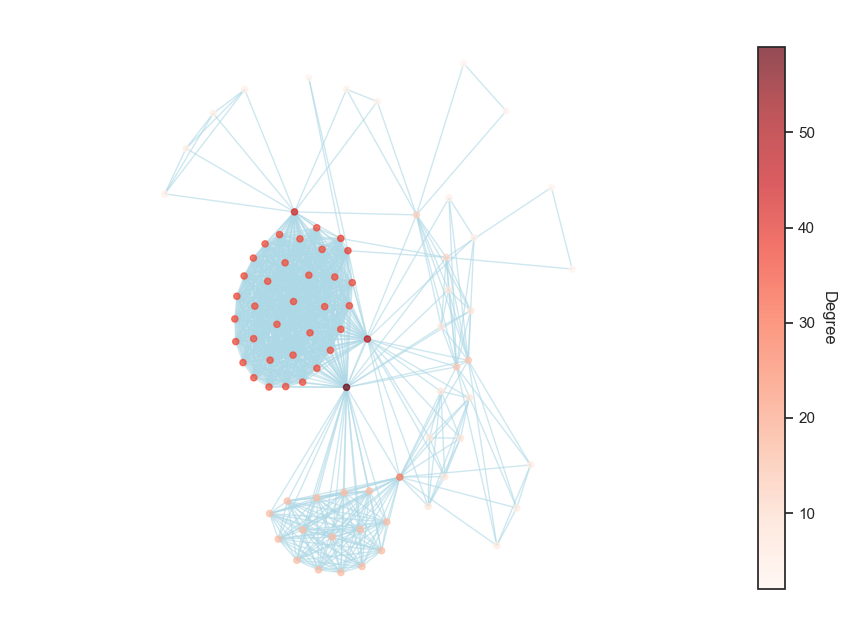

In [37]:

widths = nx.get_edge_attributes(dmn_graph, 'weight')
nodelist = dmn_graph.nodes()

plt.figure(figsize=(10,8))

pos = nx.kamada_kawai_layout(dmn_graph)
nds = nx.draw_networkx_nodes(dmn_graph,pos,
                       nodelist=nodelist,
                       node_size=20,
                       node_color=list(nx.get_node_attributes(dmn_graph, 'degree').values()),
                       cmap='Reds',
                       alpha=0.7)
nx.draw_networkx_edges(dmn_graph,pos,
                       edgelist = widths.keys(),
                       edge_color='lightblue',
                       alpha=0.6)

# Add a colorbar
cbar = plt.colorbar(nds, fraction=0.035, pad=0.04)
cbar.ax.set_ylabel('Degree', rotation=-90, va="bottom")

plt.box(False)
plt.margins(x=0.3)
plt.show()


In [38]:
(biadj_df.sum(axis=0) > 2).sum()

10

In [ ]:
study_contributions = biadj_df.divide(biadj_df.sum(axis=0), axis=1)
# add contribution from each study 
nx.set_node_attributes(dmn_graph, study_contributions.to_dict())

In [ ]:
# add direction of metabolite changes
dirs = [pd.Series(i.pval_df['Direction'], name=i.id) for i in studies]
dirs = [d[~d.index.duplicated(keep='first')] for d in dirs]

In [41]:
dirs = [d.replace({'Up': 1, 'Down': -1}) for d in dirs]

C:\Users\cw2019\AppData\Local\Temp\ipykernel_22064\2459888317.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dirs = [d.replace({'Up': 1, 'Down': -1}) for d in dirs]


In [42]:
dirs_all = pd.concat(dirs, axis=1)

In [69]:
dirs_all.head()

,MTBLS2014,MTBLS1866,MTBLS2224,MTBLS2542,MTBLS2291,MTBLS2336
137682,-1.0,NaN,NaN,NaN,NaN,NaN
15428,1.0,-1.0,1.0,NaN,NaN,-1.0
15611,-1.0,NaN,NaN,NaN,NaN,NaN
15891,1.0,NaN,1.0,-1.0,NaN,NaN
16000,1.0,1.0,1.0,NaN,NaN,NaN


In [43]:
for i in studies:
    nx.set_node_attributes(dmn_graph, dirs_all[i.id], i.id+'_direction')

Add CHEBI names

In [44]:
def add_names_to_graph(edgelist, nx_graph):
    graph = nx_graph.copy()
    edgelist_df = edgelist.copy()
    # get names and mass of all compounds of interest
    cpds_of_interest = list(set(edgelist_df['source'].tolist()))  
    chebi_names = {}
    chebi_mass = {}
    for c in cpds_of_interest:
        try:
            chebi_names[c] = libchebipy.ChebiEntity(c).get_name()
            chebi_mass[c] = libchebipy.ChebiEntity(c).get_mass()
        except:
            pass
    edgelist_df['Source_Name'] = edgelist_df['source'].map(chebi_names)
    edgelist_df['Source_Mass'] = edgelist_df['source'].map(chebi_mass)
    
    nx.set_node_attributes(graph, chebi_names, 'name')
    nx.set_node_attributes(graph, chebi_mass, 'mass')
    
    return edgelist_df, graph
    

In [45]:
edgelist_names, dmn_graph_names = add_names_to_graph(edgelist_dmn, dmn_graph)

In [73]:
dmn_graph_names

In [46]:
# add chebi ontology via ClassyFire
classyfire = pd.read_csv('ChEBI_126_classyfire_21_annotations.csv', on_bad_lines='skip')

In [57]:
import bioontologies
import obonet

In [73]:
# load ontology file
chebi_ontology = obonet.read_obo('ChemOnt_2_1.obo')

In [99]:
def get_chem_class(chemont_id):
    try:
        chem_class = chebi_ontology.nodes[chemont_id]['is_a']
        super_class = chebi_ontology.nodes[chem_class[0]]['name']
    except KeyError:
        chem_class = None
        super_class = None
    return super_class

In [47]:
classyfire['CompoundID'] = classyfire['CompoundID'].astype(str)

In [59]:
classyfire.head()

,CompoundID,Smiles,ChemOntID,ParentName
0,90,CHEMONTID:0003410,1-benzopyrans,NaN
1,90,CHEMONTID:0004646,1-hydroxy-2-unsubstituted benzenoids,NaN
2,90,CHEMONTID:0004647,1-hydroxy-4-unsubstituted benzenoids,NaN
3,90,CHEMONTID:0002915,3'-hydroxyflavonoids,NaN
4,90,CHEMONTID:0002914,3-hydroxyflavonoids,NaN


In [69]:
cpds_of_interest = list(dmn_graph_names.nodes())

In [70]:
len(cpds_of_interest)

82

In [71]:
classyfire_ont_filt = classyfire[classyfire['CompoundID'].isin(cpds_of_interest)]

In [72]:
classyfire_ont_filt

,CompoundID,Smiles,ChemOntID,ParentName
9029,15428,CHEMONTID:0002404,Alpha amino acids,NaN
9030,15428,CHEMONTID:0000060,Alpha amino acids and derivatives,NaN
9031,15428,CHEMONTID:0002449,Amines,NaN
9032,15428,CHEMONTID:0004176,Amino acids,NaN
9033,15428,CHEMONTID:0000347,Amino acids and derivatives,NaN
...,...,...,...,...
2686196,545687,CHEMONTID:0000000,Organic compounds,NaN
2686197,545687,CHEMONTID:0003940,Organic oxides,NaN
2686198,545687,CHEMONTID:0004603,Organic oxygen compounds,NaN
2686199,545687,CHEMONTID:0000323,Organooxygen compounds,NaN


In [100]:
classyfire_ont_filt['SuperClass'] = classyfire_ont_filt['Smiles'].apply(lambda x: get_chem_class(x))

C:\Users\cw2019\AppData\Local\Temp\ipykernel_22064\1035017966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classyfire_ont_filt['SuperClass'] = classyfire_ont_filt['Smiles'].apply(lambda x: get_chem_class(x))


In [102]:
nx.set_node_attributes(dmn_graph_names, dict(zip(classyfire_ont_filt['CompoundID'], classyfire_ont_filt['SuperClass'])), 'classyfire')

In [103]:
# export network
nx.write_graphml(dmn_graph_names, 'covid_metabolites_dmn_04_12_24.graphml')

## Upset plot of metabolites

In [7]:
# filter most commonly co-occurring metabolites
freq_met = biadj_df.loc[:, (biadj_df.sum() > 1)]

# differential metabolite cooccurences
all_da_sets = [set(i.DA_metabolites) for i in studies]

# most commonly cooccuring metabolites sets
co_occuring_sets = freq_met.apply(lambda row: set(freq_met.columns[row == 1]), axis=1).tolist()


NameError: name 'biadj_df' is not defined

In [76]:
freq_met

,30746,17697,30813,24813,16000,30851,15908,37550,18257,27226,...,17361,18050,16977,15428,89644,16958,89633,75455,15741,17295
MTBLS1866,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,1,0
MTBLS2014,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
MTBLS2336,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,1
MTBLS2291,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MTBLS2542,0,1,1,1,0,1,1,1,1,1,...,1,1,0,0,1,1,1,0,0,0
MTBLS2224,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,1,1,0,1,1,1


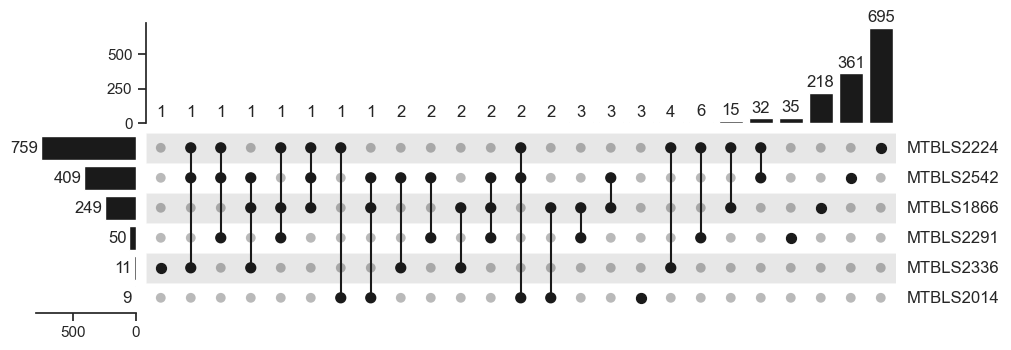

In [77]:
# look at where differential metabolites occur
upset_data = UpsetData.from_sets(all_da_sets, sets_names=[i.node_name for i in studies])
us = ma.upset.Upset(
    data=upset_data, 
    orient="h",
    add_labels=True,
    )


us.add_legends(box_padding=0)
us.set_margin(0.3)
us.render()

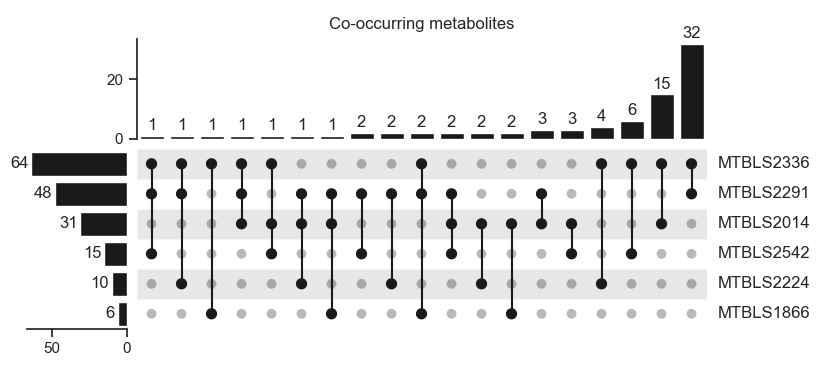

In [78]:
# look at co-occuring da metabolites
upset_data = UpsetData.from_sets(
    co_occuring_sets, 
    sets_names=[i.node_name for i in studies])

us = ma.upset.Upset(
    data=upset_data, 
    orient="h",
    add_labels=True,
    )


us.add_legends(box_padding=0)
us.set_margin(0.3)

us.add_title(top="Co-occurring metabolites")

us.render()

Then do a plot of the most frequently co-occuring metabolites and add the direction of FC.

In [100]:
edgelist_names

,source,target,weight,Source_Name,Source_Mass
25102,6650,6650,2,malic acid,134.08744
25114,6650,86259,2,malic acid,134.08744
25130,6650,1148,2,malic acid,134.08744
25168,6650,320055,2,malic acid,134.08744
25175,6650,16857,2,malic acid,134.08744
...,...,...,...,...,...
12783371,30830,26271,2,4-hydroxybutyric acid,104.10452
12783566,30830,16737,2,4-hydroxybutyric acid,104.10452
12783592,30830,30805,2,4-hydroxybutyric acid,104.10452
12783913,30830,17368,2,4-hydroxybutyric acid,104.10452


In [79]:
# filter most commonly co-occurring metabolites
freq_met = biadj_df.loc[:, (biadj_df.sum() > 2)].columns.tolist()

# chebi names dict
chebi_names = dict(zip(edgelist_names['source'], edgelist_names['Source_Name']))

# df of da results for each metabolite in each study
stat_per_study = []
for i in studies:
    df = i.pval_df.copy()
    df = df[df.index.isin(freq_met)]
    df.loc[:,'Study'] = i.node_name
    df.loc[:, 'ChEBI'] = df.index
    df.loc[:, 'Metabolite_name'] = df.index.map(chebi_names)
    
    stat_per_study.append(df)

stat_per_study_df = pd.concat(stat_per_study)

C:\Users\cw2019\AppData\Local\Temp\ipykernel_197916\2079178108.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


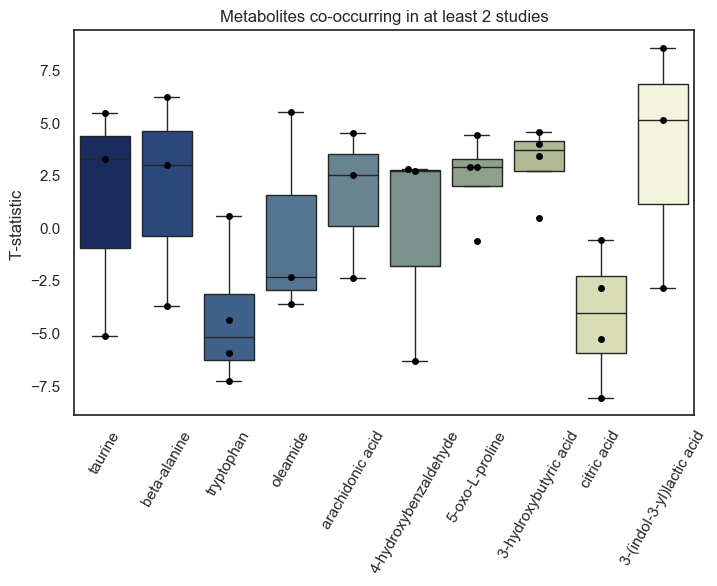

In [80]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(
    data=stat_per_study_df,
    x='Metabolite_name',
    y='Stat',
    palette='cmc.davos',
    ax=ax,
    showfliers=False,
    # hue='Study'
)

sns.swarmplot(
    data=stat_per_study_df,
    x='Metabolite_name',
    y='Stat',
    color='black',
    ax=ax,
    # hue='Study'
)

plt.title('Metabolites co-occurring in at least 2 studies')
plt.ylabel('T-statistic ')
plt.xlabel('')
plt.xticks(rotation=60)
plt.show()

### Check if any of these overlap in the validation set

In [107]:
freq_met

['24813',
 '15843',
 '15891',
 '30769',
 '17597',
 '18183',
 '20067',
 '27897',
 '116314',
 '16958']

In [81]:
s6739_da_mets = s6739.DA_metabolites 
s6739_pval_df = s6739.pval_df
s6739_pval_df = s6739_pval_df[s6739_pval_df.index.isin(freq_met)]
s6739_pval_df.loc[:,'Study'] = s6739.node_name
s6739_pval_df.loc[:, 'ChEBI'] = s6739_pval_df.index
s6739_pval_df.loc[:, 'Metabolite_name'] = s6739_pval_df.index.map(chebi_names)
# overlap_validation = set(s6739_da_mets).intersection(set(freq_met))

C:\Users\cw2019\AppData\Local\Temp\ipykernel_197916\1617261115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s6739_pval_df.loc[:,'Study'] = s6739.node_name
C:\Users\cw2019\AppData\Local\Temp\ipykernel_197916\1617261115.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s6739_pval_df.loc[:, 'ChEBI'] = s6739_pval_df.index
C:\Users\cw2019\AppData\Local\Temp\ipykernel_197916\1617261115.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [123]:
s6739_pval_df

,P-value,Stat,Direction,FDR_P-value,Study,ChEBI,Metabolite_name
15891,0.001672,3.187282,Up,0.003025,MTBLS6739,15891,taurine
18183,0.000250,3.730675,Up,0.000528,MTBLS6739,18183,5-oxo-L-proline
27897,0.000006,-4.668223,Down,0.000018,MTBLS6739,27897,tryptophan


In [117]:
overlap_validation

{'15891', '18183', '27897'}

In [120]:
s6739_pval_df[s6739_pval_df.index.isin(overlap_validation)]

,P-value,Stat,Direction,FDR_P-value
15891,0.001672,3.187282,Up,0.003025
18183,0.000250,3.730675,Up,0.000528
27897,0.000006,-4.668223,Down,0.000018


In [ ]:
stat_per_study = []
for i in studies:
    df = i.pval_df.copy()
    stat_per_study.append(df)

In [102]:
validation_studies = [s6739, s3852]

stat_per_study_validation = []
for i in validation_studies:
    df = i.pval_df.copy()
    df = df[df.index.isin(freq_met)]
    df.loc[:,'Study'] = i.node_name
    df.loc[:, 'ChEBI'] = df.index
    df.loc[:, 'Metabolite_name'] = df.index.map(chebi_names)
    
    stat_per_study_validation.append(df)

stat_per_study_validation_df = pd.concat(stat_per_study_validation)

In [106]:
stat_per_study_validation_df

,P-value,Stat,Direction,FDR_P-value,Study,ChEBI,Metabolite_name
15891,0.001672,3.187282,Up,0.003025,MTBLS6739,15891,taurine
18183,0.000250,3.730675,Up,0.000528,MTBLS6739,18183,5-oxo-L-proline
27897,0.000006,-4.668223,Down,0.000018,MTBLS6739,27897,tryptophan
15891,0.000288,3.818088,Up,0.000743,MTBLS3852,15891,taurine


C:\Users\cw2019\AppData\Local\Temp\ipykernel_197916\2394084346.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


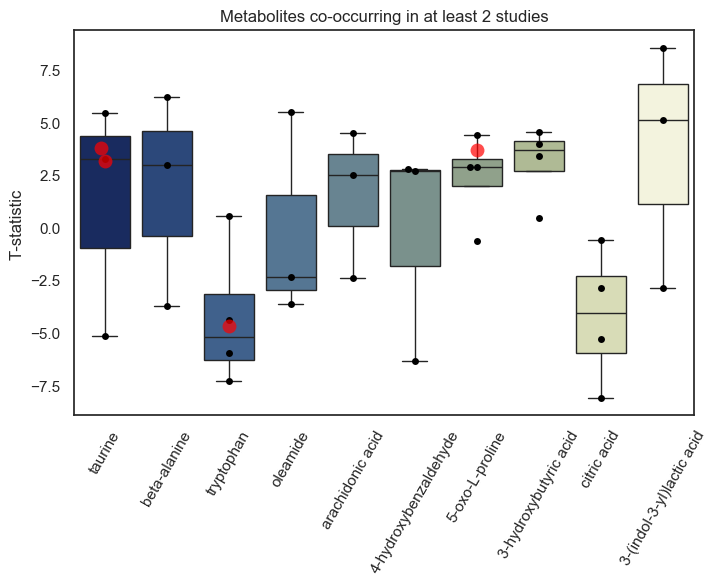

In [137]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(
    data=stat_per_study_df,
    x='Metabolite_name',
    y='Stat',
    palette='cmc.davos',
    ax=ax,
    showfliers=False,
    # hue='Study'
)

sns.swarmplot(
    data=stat_per_study_df,
    x='Metabolite_name',
    y='Stat',
    color='black',
    ax=ax,
    # hue='Study'
)

sns.swarmplot(
    data=stat_per_study_validation_df,
    x='Metabolite_name',
    y='Stat',
    color='red',
    ax=ax,
    s=10,
    alpha=0.7
    # hue='Study'
)

plt.title('Metabolites co-occurring in at least 2 studies')
plt.ylabel('T-statistic ')
plt.xlabel('')
plt.xticks(rotation=60)
plt.savefig('COVID_boxplots_2_ormore_cooccurences_validation.png', dpi=350, bbox_inches='tight')
plt.show()

In [109]:
# pie charts for node contribution
study_contributions_filt = study_contributions.loc[:, freq_met]

study_contributions_filt

,24813,15843,15891,30769,17597,18183,20067,27897,116314,16958
MTBLS1866,0.000000,0.333333,0.000000,0.000000,0.333333,0.333333,0.333333,0.333333,0.333333,0.000000
MTBLS2014,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333
MTBLS2336,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000
MTBLS2291,0.333333,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000
MTBLS2542,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.000000,0.333333
MTBLS2224,0.333333,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333


In [141]:
stat_per_study_df.index.unique()

Index(['15891', '16958', '27897', '116314', '15843', '17597', '18183', '20067',
       '30769', '24813'],
      dtype='object')

In [134]:
sns.color_palette('Set3')

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (1.0, 0.9294117647058824, 0.43529411764705883)]

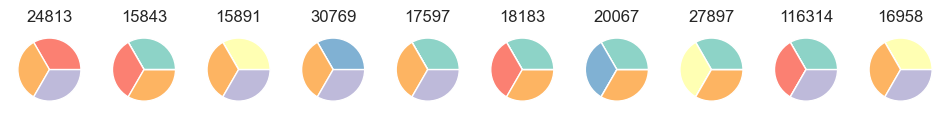

In [226]:
import matplotlib.colors as mcolors
study_cmap_cytoscape = {
    'MTBLS1866': sns.color_palette('Set3')[0],
    'MTBLS2014': sns.color_palette('Set3')[1],
    'MTBLS2224': sns.color_palette('Set3')[2],
    'MTBLS2291': sns.color_palette('Set3')[3],
    'MTBLS2336': sns.color_palette('Set3')[4],
    'MTBLS2542': sns.color_palette('Set3')[5],
}
pal = sns.color_palette(study_cmap_cytoscape.values())

fig, axs = plt.subplots(1, study_contributions_filt.shape[1], figsize=(12, 1.5))

for i, col in enumerate(study_contributions_filt.columns):
    study_contributions_filt[col].plot.pie(ax=axs[i], labels=None, colors=[study_cmap_cytoscape[c] for c in study_contributions_filt.index])
    axs[i].set_title(col)
    axs[i].set_ylabel('')

plt.savefig('COVID_DA_metabolite_contributions_pie.png', dpi=350, bbox_inches='tight')

In [213]:
study_contributions_filt_names = [chebi_names[c] for c in study_contributions_filt.columns]

In [214]:
study_contributions_filt_names

['3-(indol-3-yl)lactic acid',
 'arachidonic acid',
 'taurine',
 'citric acid',
 '4-hydroxybenzaldehyde',
 '5-oxo-L-proline',
 '3-hydroxybutyric acid',
 'tryptophan',
 'oleamide',
 'beta-alanine']

C:\Users\cw2019\AppData\Local\Temp\ipykernel_197916\904977866.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


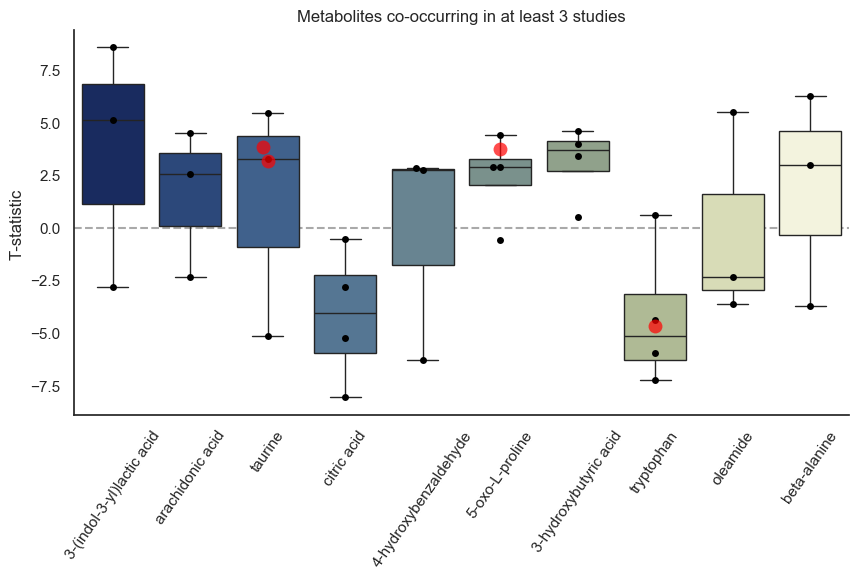

In [225]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(
    data=stat_per_study_df,
    order=study_contributions_filt_names,
    x='Metabolite_name',
    y='Stat',
    palette='cmc.davos',
    ax=ax,
    showfliers=False,
    # hue='Study'
)

sns.swarmplot(
    data=stat_per_study_df,
    order=study_contributions_filt_names,
    x='Metabolite_name',
    y='Stat',
    color='black',
    ax=ax,
    # hue='Study'
)

sns.swarmplot(
    data=stat_per_study_validation_df,
    order=study_contributions_filt_names,
    x='Metabolite_name',
    y='Stat',
    color='red',
    ax=ax,
    s=10,
    alpha=0.7
    # hue='Study'
)

ax.axhline(0, color='darkgrey', linestyle='--', zorder=1)

plt.title('Metabolites co-occurring in at least 3 studies')
plt.ylabel('T-statistic ')
plt.xlabel('')
sns.despine()
plt.xticks(rotation=55)
plt.savefig('COVID_boxplots_2_ormore_cooccurences_validation.png', dpi=350, bbox_inches='tight')
plt.show()

For a metabolite of interest, look at the abundance level in the processed data

In [103]:
metab_of_interest = '18183'
abundance_vals = []
for i in studies:
    try:
        abundance = pd.DataFrame(i.processed_data.loc[:, [metab_of_interest, 'Group']])
        md_name_dict = dict(zip(i.md_filter.values(), i.md_filter.keys()))
        abundance['Group'] = abundance['Group'].map(md_name_dict)
        abundance['StudyID'] = i.node_name
        abundance_vals.append(abundance)
    except KeyError:
        pass

abundance_df = pd.concat(abundance_vals)

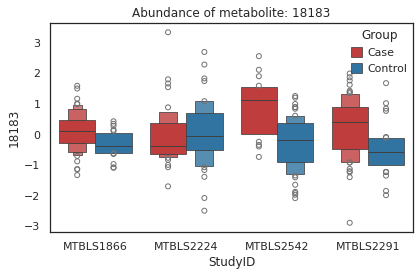

In [104]:
sns.boxenplot(
    data=abundance_df,
    x='StudyID',
    y=metab_of_interest,
    hue='Group',
    palette={'Case':'tab:red', 'Control':'tab:blue'},
    # cmap
)

plt.title('Abundance of metabolite: '+ metab_of_interest)
plt.tight_layout()
plt.show()

In [105]:
stat_per_study_df.head()

,P-value,Stat,Direction,FDR_P-value,Study,ChEBI,Metabolite_name
15891,0.000002,5.446876,Up,0.000021,MTBLS2014,15891,taurine
16958,0.004648,2.975641,Up,0.017041,MTBLS2014,16958,beta-alanine
27897,0.000067,-4.383241,Down,0.000317,MTBLS2014,27897,tryptophan
116314,0.022190,-2.326908,Down,0.043375,MTBLS1866,116314,oleamide
15843,0.000018,4.523364,Up,0.000110,MTBLS1866,15843,arachidonic acid


Add significance testing using `statannotations` package

In [106]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

stat_per_study_df_filt = stat_per_study_df[stat_per_study_df['ChEBI'] == metab_of_interest]
pvalue_asterisks = [convert_pvalue_to_asterisks(p) for p in stat_per_study_df_filt['FDR_P-value']]

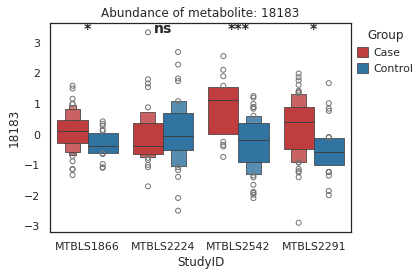

In [107]:
fig, ax = plt.subplots()
fig.subplots_adjust(top=0.44)
sns.boxenplot(
data=abundance_df,
x='StudyID',
y=metab_of_interest,
hue='Group',
palette={'Case':'tab:red', 'Control':'tab:blue'},
# cmap
)

y_position = abundance_df[metab_of_interest].max() * 1
for idx, pval in enumerate(pvalue_asterisks):
    plt.text(x=idx, y=y_position, s=pval, ha='center', fontsize=14, fontweight='bold')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Abundance of metabolite: '+ metab_of_interest)
plt.tight_layout()
plt.show()